## Implementation of ARSOM -  Association Rule Selection Optimization Model

We will use 'Association Rule Mining' and 'Mixed-Integer Programming'  to find the optimal rule set to correctly predict the positive class while minimizing the number of features used for prediction.


In [63]:
# Python Dataframe & numeric libraries
import pandas as pd
import numpy as np

# Association rule mining library
from mlxtend.frequent_patterns import apriori, association_rules

# Gurobi optimization library
import gurobipy as gp
from gurobipy import GRB

# Evaluation & Visualization libraries
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

### Read the data into pandas dataframe

Here we read the provided dataset which will be Matrix 'A' that represents ['datapoints' X 'features'].
- Column name for feature that resprents class must be 'Class'.
- Any unnecessary can be removed by passing their name in the list.

In [64]:
df = pd.read_csv('data-group1.csv')

# Rename Class variable
df.rename(columns={'case': 'Class'},inplace=True)

# Remove columns not required
df.drop(columns = ['System3','TRIAGE'], inplace=True)

df

,Class,elderly,DM,HTN,CAD,CVA,cls_CPC,RESP,CHF,LC,...,ER_USVhema,ER_USVmeta,ER_USV1.0,ER_USV_RSD,ER_USV5,ER_USV7,ER_USV8,ER_USV9,ER_USV10,ER_USV11
0,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,1,0,1,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
349,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
351,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


### Function definition for calculating coverage

- Coverage for a rule/feature is defined by number of positive/negative points covered by them.



In [65]:
def coverage(rule,klass):
    """ Function used to calculate coverage of a rule"""
    return(sum(df.loc[df['Class']==klass][rule].apply(lambda x: all(x), axis = 1)))

def check_rules(num,rules):
    """ Function used to create matrix C"""
    lis = []
    for i in rules.index:
        lis.append(int(all(df[rules['itemsets'][i]].loc[num])))
    return lis

def check_rules_features():
    itemsets_unraveled = arules.explode('itemsets')['itemsets']
    rules_features = pd.DataFrame(data = 0, index = df.columns[:-1], columns = arules.index)

    for i in itemsets_unraveled.iteritems():
        rules_features.loc[i[1]][i[0]] = 1
        
    return rules_features



## 1. Selecting relevant rules using Association rules

### Approach 'A': Regular Association rules

First we implement regular association rules technique that considers class as a feature(item).
Conclusively, we find out the association rules with class = 1.

- Here we mine for frequent itemsets using 'apriori algorithm'

In [66]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.390935,(Class)
1,0.515581,(elderly)
2,0.388102,(DM)
3,0.427762,(HTN)
4,0.121813,(CAD)
...,...,...
4309,0.016997,"(cls_CPC, CVA, ER_USV20, HTN, elderly, ER_USV_..."
4310,0.011331,"(cls_CPC, CVA, ER_USV20, ER_USV24, elderly, ER..."
4311,0.014164,"(cls_CPC, CVA, ER_USV20, HTN, ER_USV24, elderl..."
4312,0.011331,"(cls_CPC, CVA, Class, HTN, ER_USV20, elderly, ..."


- Next, we select association rules with only 'Class' in RHS(consequent) since this will represent rules to identify positive class. 
- Coverage is calculated for both + (Tcovered) and - (Ncovered) datapoints.

In [67]:
arules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
arules = arules[arules['consequents'] == frozenset({'Class'})]
arules = arules[['antecedents','support','confidence','lift']]
arules['size'] = arules['antecedents'].apply(lambda x: len(x))
arules['Tcovered'] = arules['antecedents'].apply(lambda x: coverage(x,1))
arules['Ncovered'] = arules['antecedents'].apply(lambda x: coverage(x,0))
arules.rename(columns = {'antecedents': 'itemsets'}, inplace=True)
arules.reset_index(drop=True,inplace=True)
arules['itemsets'] = arules['itemsets'].apply(lambda x: list(x))
arules

,itemsets,support,confidence,lift,size,Tcovered,Ncovered
0,[CANCE],0.070822,0.757576,1.937857,1,25,8
1,[ER_USVlowBP],0.093484,0.767442,1.963094,1,33,10
2,[ER_USV14],0.090652,0.864865,2.212299,1,32,5
3,[ER_USV15],0.022663,0.800000,2.046377,1,8,2
4,[ER_USVhema],0.059490,0.750000,1.918478,1,21,7
...,...,...,...,...,...,...,...
1350,"[ER_USV20, cls_CPC, CVA, ER_USV24, elderly, ER...",0.016997,0.857143,2.192547,7,6,1
1351,"[ER_USV20, cls_CPC, CVA, HTN, ER_USV21, ER_USV...",0.011331,1.000000,2.557971,7,4,0
1352,"[ER_USV20, cls_CPC, CVA, HTN, ER_USV24, ER_USV...",0.011331,1.000000,2.557971,7,4,0
1353,"[ER_USV20, cls_CPC, CVA, HTN, ER_USV24, ER_USV...",0.014164,1.000000,2.557971,7,5,0


- Matrix B is ['rules' X 'features'] matrix. For each rule we check if the feature is covered and mark it 1.

In [68]:
#Matrix B
rules_features = check_rules_features()
rules_features

,0,1,2,3,4,5,6,7,8,9,...,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354
Class,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
elderly,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,0,0,0,1
DM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
HTN,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,1
CAD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CVA,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
cls_CPC,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,1
RESP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LC,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


- Matrix C is a ['datapoint' X 'rules'] matrix and we use check_rules() function to create it.

In [69]:
#Matrix C

df_rules_data = [check_rules(x,arules) for x in df.index]
df_rules = pd.DataFrame(data = df_rules_data, index = df.index, columns = arules.index)
df_rules['Class'] = df['Class']

df_rules

,0,1,2,3,4,5,6,7,8,9,...,1346,1347,1348,1349,1350,1351,1352,1353,1354,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
351,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**NOTE:** SKIP TO **STEP 2. OPTIMIZATION** IF THE APPROACH 'A' WORKED ON DATASET.

### Approach 'B': Using frequent itemsets and their support as P(Class = 1 | Rule)

This approach is to be used only if approach 'A' is not feasible in case of a significantly large dataset.

- Separate true cases for class = 1

In [51]:
df_class1 = df[df.Class == 1].copy()

df_class1.drop(columns = ['Class'], inplace = True)

df_class1

,elderly,DM,HTN,CAD,CVA,cls_CPC,RESP,CHF,LC,ESRD,...,ER_USVhema,ER_USVmeta,ER_USV1.0,ER_USV_RSD,ER_USV5,ER_USV7,ER_USV8,ER_USV9,ER_USV10,ER_USV11
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1,0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
134,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136,1,0,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


 - Mining frequent itemsets using *'apriori algorithm'* and calculating coverage

In [52]:
frequent_itemsets = apriori(df_class1, min_support=0.03, use_colnames = True)

arules = frequent_itemsets

arules['size'] = arules['itemsets'].apply(lambda x: len(x))
arules['Tcovered'] = arules['itemsets'].apply(lambda x: coverage(x,1))
arules['Ncovered'] = arules['itemsets'].apply(lambda x: coverage(x,0))
arules['itemsets'] = arules['itemsets'].apply(lambda x: list(x))
arules

,support,itemsets,size,Tcovered,Ncovered
0,0.637681,[elderly],1,88,94
1,0.485507,[DM],1,67,70
2,0.456522,[HTN],1,63,88
3,0.181159,[CAD],1,25,18
4,0.282609,[CVA],1,39,39
...,...,...,...,...,...
1345,0.036232,"[ER_USV20, CVA, HTN, ER_USV24, elderly, ER_USV...",7,5,1
1346,0.036232,"[ER_USV20, cls_CPC, HTN, ER_USV24, elderly, ER...",7,5,0
1347,0.043478,"[ER_USV20, cls_CPC, CVA, ER_USV24, elderly, ER...",7,6,1
1348,0.036232,"[ER_USV20, cls_CPC, CVA, HTN, ER_USV24, ER_USV...",7,5,0


- Matrix B is ['rules' X 'features'] matrix. For each rule we check if the feature is covered and mark it 1.

In [53]:
#Matrix B

rules_features = check_rules_features()
rules_features

,0,1,2,3,4,5,6,7,8,9,...,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349
Class,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
elderly,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
DM,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
HTN,0,0,1,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,1
CAD,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CVA,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,0,1,1,1
cls_CPC,0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,1,0,1,1,1,1
RESP,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHF,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
LC,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


- Matrix C is a ['datapoint' X 'rules'] matrix and we use check_rules() function to create it.

In [54]:
#Matrix C

df_rules_data = [check_rules(x,arules) for x in df.index]
df_rules = pd.DataFrame(data = df_rules_data, index = df.index, columns = arules.index)
df_rules['Class'] = df['Class']

df_rules

,0,1,2,3,4,5,6,7,8,9,...,1341,1342,1343,1344,1345,1346,1347,1348,1349,Class
0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
349,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
350,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
351,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 2. OPTIMIZATION: Finding optimal rule set using integer programming

### Define the problem:


Our optimization problem is as follows:

**MIN:** $\alpha\  \Sigma y_j$ + $\beta \  \Sigma z_k$ + $\gamma \  \Sigma x_i^-$ - $\lambda \  \Sigma x_i^+$

**ST:**  $\Sigma$ $ c_{ik}^+ z_k \ge x_i \ \  \forall \  i \in I^+ $

$\Sigma$ $ c_{ik}^- z_k \ge M_1 x_i \ \  \forall \  i \in I^- $

$\Sigma$ $ b_{jk}^- z_k \ge M_2 y_j \ \  \forall \  j \in J $

- Check the problem parameters (change 'l' if needed) in Gurobi and run the optimization model in following cell

In [70]:
gp.disposeDefaultEnv()

J,K,I_P,I=len(rules_features.index),len(rules_features.columns),df['Class'].sum(),len(df.index)

c_P_df = df_rules.loc[df_rules['Class'] == 1, df_rules.columns !='Class'].reset_index(drop=True).transpose()

c_N_df = df_rules.loc[df_rules['Class'] == 0, df_rules.columns !='Class'].reset_index(drop=True).transpose()

bf = rules_features.reset_index(drop = True).transpose()

# SET the lambda coefficient
l = 999

Freeing default Gurobi environment


In [71]:
try:
    # Create a new model
    A = gp.Model("mip1")
    
    # Create variables
    x = A.addVars(I, vtype=GRB.BINARY, name="x")
    #xneg = A.addVars(10, vtype=GRB.BINARY, name="xneg")
    y = A.addVars(J, vtype=GRB.BINARY, name="y")
    z = A.addVars(K, vtype=GRB.BINARY, name="z")
    
    # Set objective
    
    A.setObjective(gp.quicksum(y[j] for j in range(J))+
                   gp.quicksum(z[k] for k in range(K))+
                   gp.quicksum(x[i] for i in range(I_P,I))-
                   l*gp.quicksum(x[i] for i in range(I_P)),
                   GRB.MINIMIZE)
    
    # Add constraint: sigma{c_i_k+ * z_k} >= x_i
    for i in range(I_P):
        A.addConstr(gp.quicksum(c_P_df[i][k] * z[k] for k in range(K))>= x[i], name='con1')
    
    # Add constraint: sigma{c_i_k- * z_k} <= M_1 * x_i
    for i in range(I_P,I):
        i1=i-I_P
        A.addConstr(gp.quicksum(c_N_df[i1][k] * z[k] for k in range(K))<= (K+1) * x[i], name='con2')
    
    # Add constraint: sigma{b_j_k * z_k} <= M_2 * y_j
    for j in range(J):
        A.addConstr(gp.quicksum(bf[j][k] * z[k] for k in range(K))<= (K+1) * y[j], name='con3')
    
    # Optimize model
    A.optimize()
    
    for v in A.getVars():
            print('%s %g' % (v.varName, v.x))
    
    print('Obj: %g' % A.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Academic license - for non-commercial use only - expires 2021-08-09
Using license file C:\Users\tusha\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 383 rows, 1738 columns and 16313 nonzeros
Model fingerprint: 0x2071c094
Variable types: 0 continuous, 1738 integer (1738 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 198 rows and 1186 columns
Presolve time: 0.02s
Presolved: 185 rows, 552 columns, 4667 nonzeros
Found heuristic solution: objective -7969.000000
Variable types: 0 continuous, 552 integer (552 binary)

Root relaxation: objective -1.138599e+05, 114 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

- Now we subset arules dataframe to observe only the selected rules after optimization

In [72]:
z_rules = []
for v in A.getVars():
    if 'z' in v.varName:
        z_rules.append(bool(v.x))

#rules_final = [i for i in arules[z_rules].sort_values(by = 'support', ascending = False)['itemsets']]
rules_final = [i for i in arules[z_rules]['itemsets']]
rules_final

[['ER_USVlowBP'],
 ['ER_USV14'],
 ['ER_USV15'],
 ['ER_USV8'],
 ['ER_desat', 'DM'],
 ['CAD', 'CHF'],
 ['RESP', 'CVA'],
 ['ESRD', 'CVA'],
 ['ER_USV_RSD', 'CVA'],
 ['ESRD', 'cls_CPC'],
 ['CANCE', 'ER_USV24'],
 ['ER_USV20', 'ER_USVhema'],
 ['CANCE', 'ER_USV20', 'elderly'],
 ['ER_USV20', 'ER_USV25', 'DM'],
 ['ER_USV20', 'ER_USV24', 'ER_desat'],
 ['ER_USV20', 'cls_CPC', 'CVA', 'HTN', 'DM']]

## 3. Evaluation

Here we will use selected rules to predict the class of training dataset. Evaluation includes analyzing confusion matrix and the AUC plots.

- Calculate prediction probabilities for a datapoint using average support of all the rules that satisfy that datapoint.

In [73]:
y_predict_proba=[]

for j in df.index:
    colsup = []
    for i in arules[z_rules].index:
        if all(df.iloc[j,:][arules.iloc[i]['itemsets']]) == True:
            colsup.append(arules.iloc[i]['support'])
    try:
        y_predict_proba.append(sum(colsup)/len(colsup))
    except ZeroDivisionError:
        y_predict_proba.append(0)

y_predict_proba

[0,
 0,
 0.07554296506137866,
 0.06515580736543909,
 0.025495750708215296,
 0.06373937677053824,
 0.0339943342776204,
 0,
 0.0226628895184136,
 0.0481586402266289,
 0.06043437204910292,
 0.040604343720491036,
 0.05099150141643059,
 0.0906515580736544,
 0.07223796033994334,
 0,
 0.09348441926345609,
 0.07459867799811143,
 0.039660056657223795,
 0.06657223796033995,
 0.053824362606232294,
 0,
 0.09348441926345609,
 0.09348441926345609,
 0.046033994334277614,
 0,
 0.03824362606232294,
 0.0226628895184136,
 0,
 0.0226628895184136,
 0.07932011331444759,
 0.0679886685552408,
 0.042492917847025496,
 0.05099150141643059,
 0.0113314447592068,
 0.05099150141643059,
 0.05099150141643059,
 0.05311614730878188,
 0.09206798866855524,
 0.0906515580736544,
 0,
 0.039660056657223795,
 0.09348441926345609,
 0.0906515580736544,
 0.053824362606232294,
 0,
 0.09348441926345609,
 0.05099150141643059,
 0.05760151085930123,
 0.06515580736543909,
 0.07223796033994334,
 0.032577903682719546,
 0.0188857412653446

- Convert prediction probabilities to predicted class by converting to boolean.

In [74]:
y_predicted = [bool(i) for i in y_predict_proba]
y_predict_proba = np.array(y_predict_proba)

y_predicted

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 F

- Calculate and plot confusion matrix using predicted and true labels

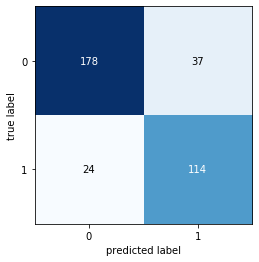

In [75]:
y_target = list(df['Class'])
cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [76]:
my_func = lambda x: 1-x

y_proba = np.vstack((y_predict_proba,[my_func(i) for i in y_predict_proba])).T
y_test = np.vstack((y_target,[my_func(i) for i in y_target])).T

y_proba

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.07554297, 0.92445703],
       [0.06515581, 0.93484419],
       [0.02549575, 0.97450425],
       [0.06373938, 0.93626062],
       [0.03399433, 0.96600567],
       [0.        , 1.        ],
       [0.02266289, 0.97733711],
       [0.04815864, 0.95184136],
       [0.06043437, 0.93956563],
       [0.04060434, 0.95939566],
       [0.0509915 , 0.9490085 ],
       [0.09065156, 0.90934844],
       [0.07223796, 0.92776204],
       [0.        , 1.        ],
       [0.09348442, 0.90651558],
       [0.07459868, 0.92540132],
       [0.03966006, 0.96033994],
       [0.06657224, 0.93342776],
       [0.05382436, 0.94617564],
       [0.        , 1.        ],
       [0.09348442, 0.90651558],
       [0.09348442, 0.90651558],
       [0.04603399, 0.95396601],
       [0.        , 1.        ],
       [0.03824363, 0.96175637],
       [0.02266289, 0.97733711],
       [0.        , 1.        ],
       [0.02266289, 0.97733711],
       [0.

- Plot the AUC curve by calculating FPR, TPR at different thresholds using roc_curve() function.

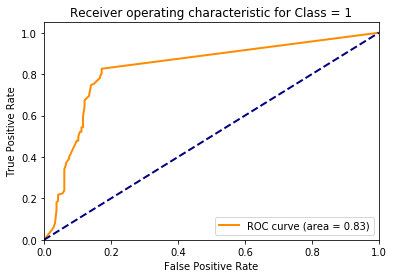

In [77]:
n_classes = len(set(df['Class']))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Class = 1')
plt.legend(loc="lower right")
plt.show()